<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/Day10_Smart_Email_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Core Concept**

Text classification - specifically applying this to categorize emails into folders like primary, social, promotions, etc.

**Process Overview**

**Data Collection/Preparation:**

You'll need an email dataset (there are public ones available)
Extract features from emails (subject line, sender, body text)
Clean and preprocess the text data


**Classification Model:**

Feature extraction (TF-IDF or word embeddings)
Train a classifier (Naive Bayes, SVM, or neural network)
Categorize emails into predefined classes


**Evaluation:**

Measure accuracy, precision, recall, F1-score
Confusion matrix to understand classification mistakes
Test on new emails to verify performance





**Key Considerations**




*  Privacy is critical when working with email data
*   
Balance between precision (avoiding false positives) and recall (catching all relevant emails)

*   Features to consider: sender domain, keywords in subject/body, email structure






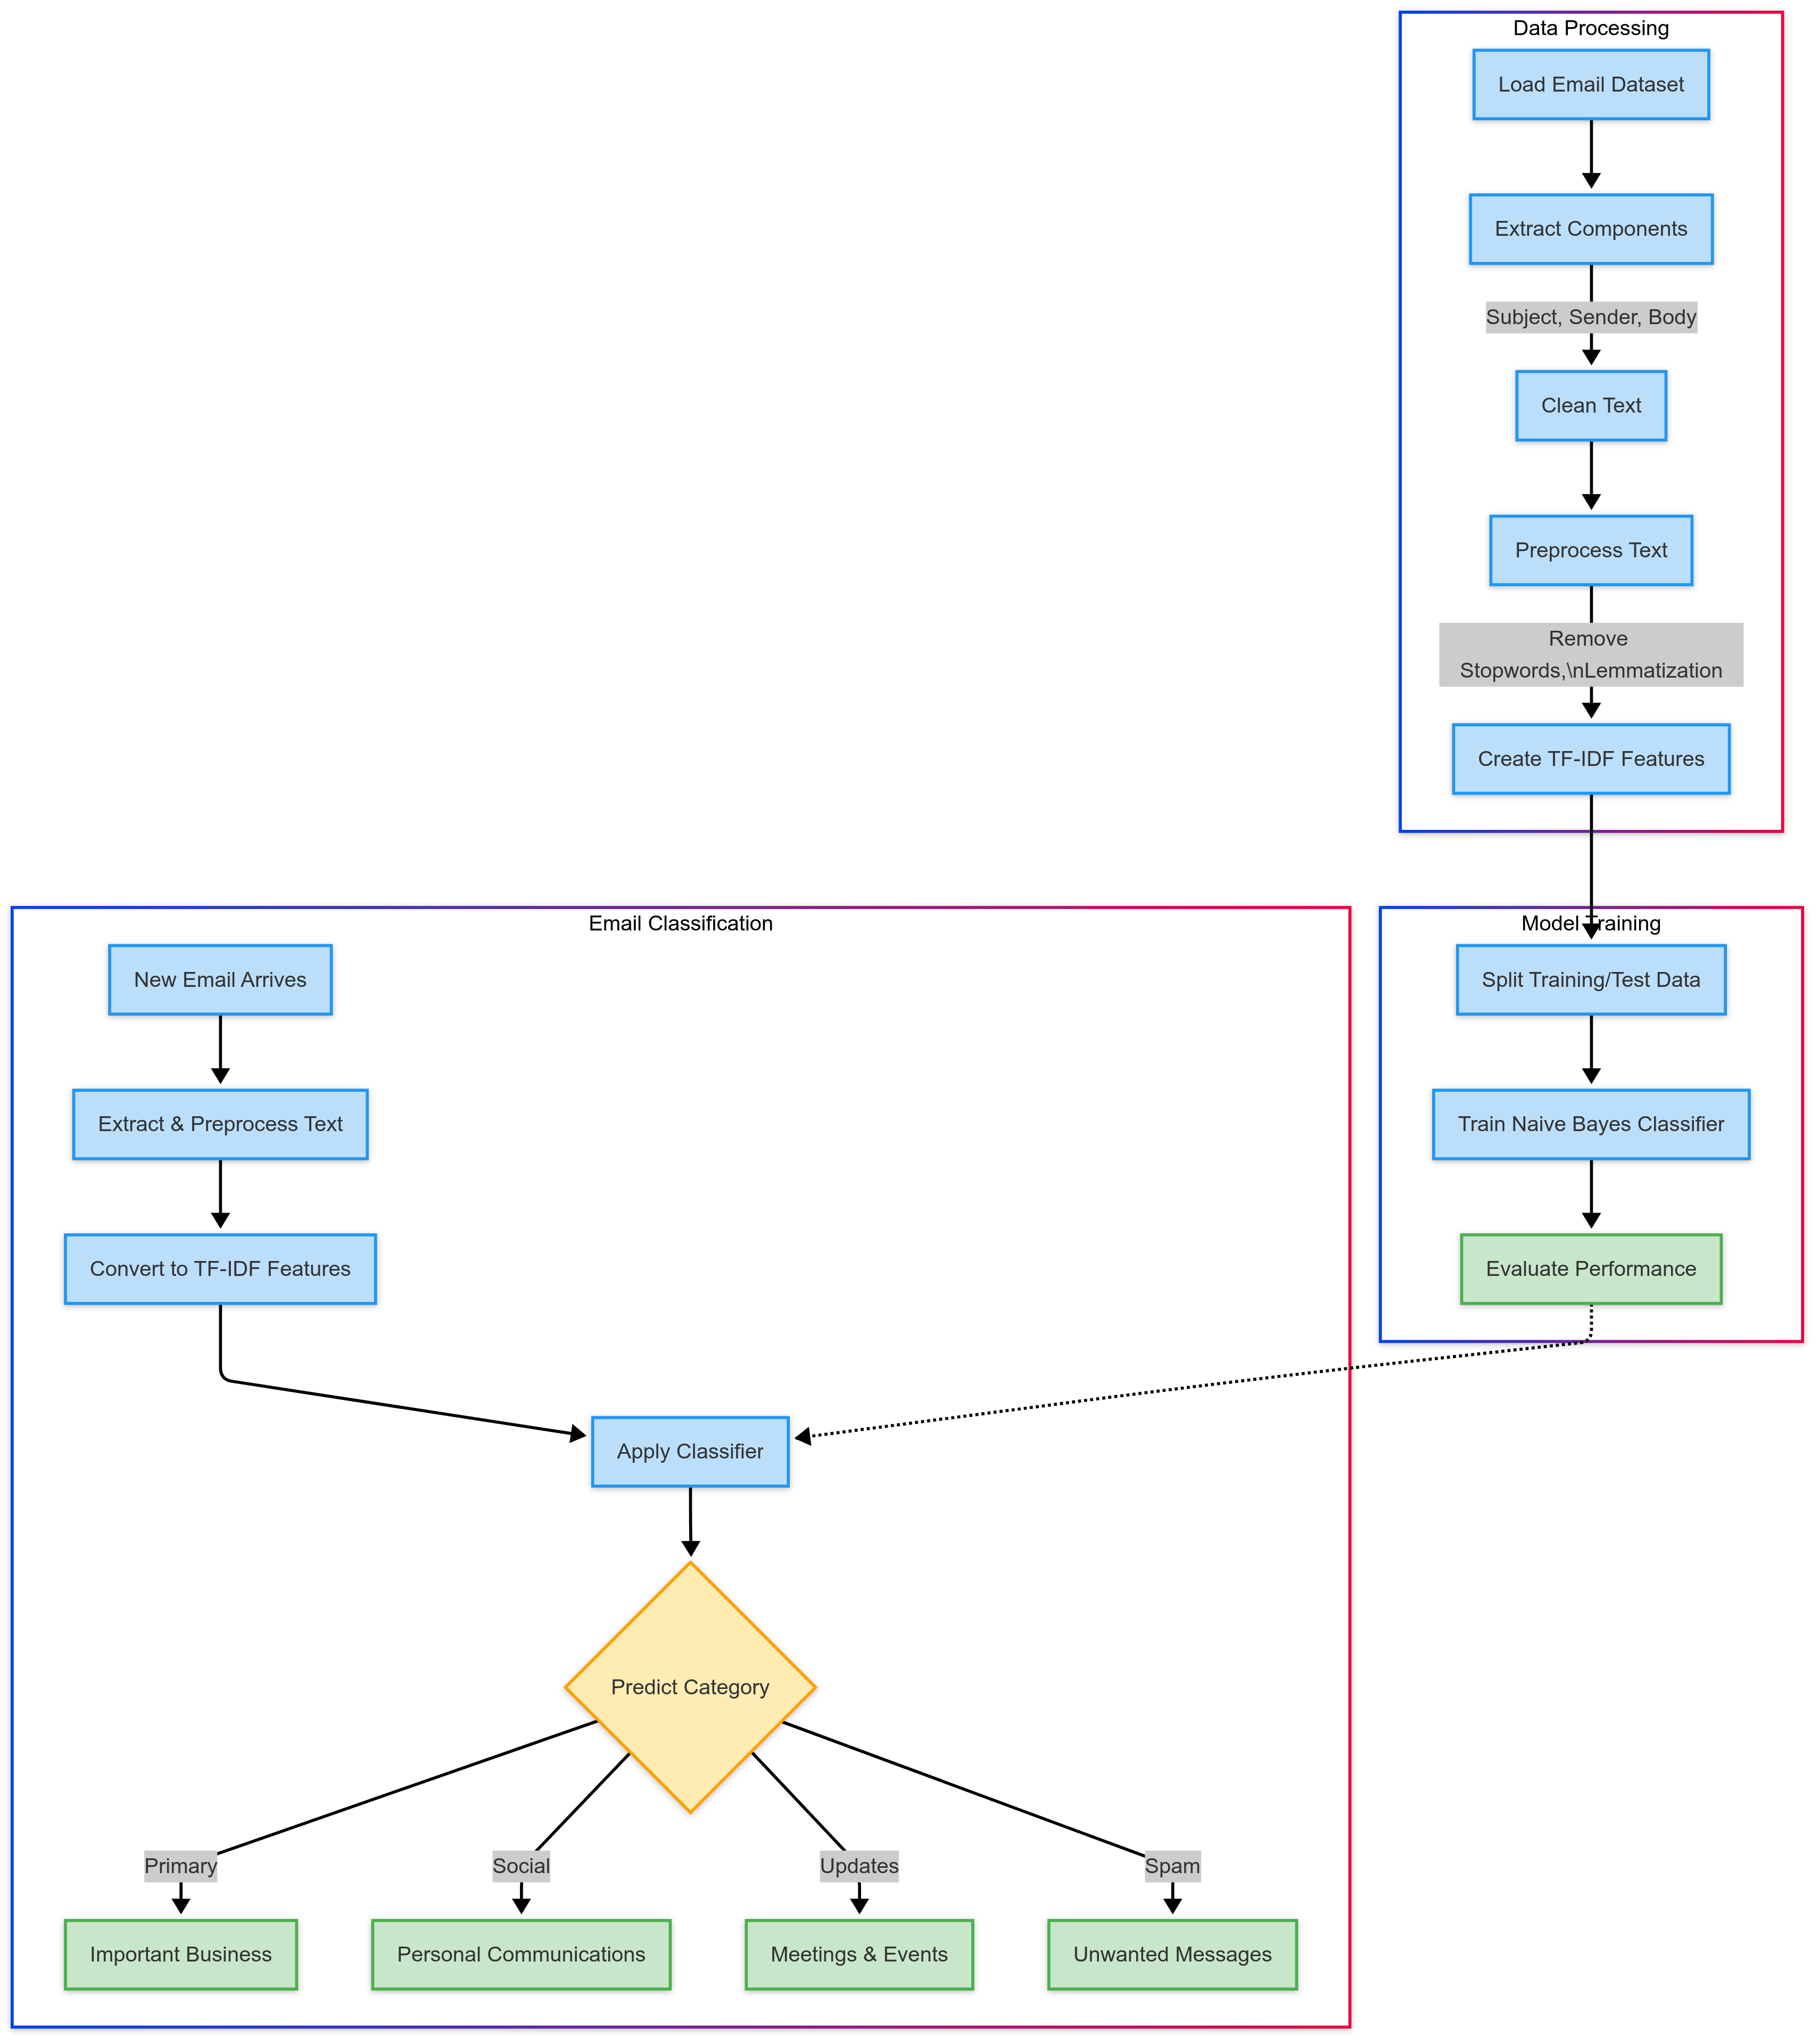

**let's download and extract the dataset in Colab**

In [1]:
# Download Enron dataset (a subset to make it manageable)
!wget https://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz -O enron_mail.tar.gz
!mkdir -p enron_mail
!tar -xzf enron_mail.tar.gz -C enron_mail

--2025-04-24 20:52:22--  https://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443254787 (423M) [application/x-gzip]
Saving to: ‘enron_mail.tar.gz’

enron_mail.tar.gz   100%[===================>] 422.72M  10.8MB/s    in 31s     

2025-04-24 20:52:53 (13.8 MB/s) - ‘enron_mail.tar.gz’ saved [443254787/443254787]



**let's explore and load the data:**

In [4]:
import os
import email
import pandas as pd
from email.parser import Parser

def extract_email_content(file_path):
    """Extract subject, sender, and body from an email file"""
    with open(file_path, 'r', encoding='latin1') as f:
        msg = Parser().parse(f)

    # Extract email details
    subject = msg['subject'] if msg['subject'] else ''
    sender = msg['from'] if msg['from'] else ''

    # Get body (try different content types)
    if msg.is_multipart():
        body = ''
        for part in msg.walk():
            content_type = part.get_content_type()
            if content_type == 'text/plain':
                body += part.get_payload(decode=True).decode('latin1', errors='ignore')
    else:
        body = msg.get_payload(decode=True).decode('latin1', errors='ignore') if msg.get_payload() else ''

    return subject, sender, body




Processed 5000 emails


,subject,sender,body,category
0,Sempra Litigation,wayne.gresham@enron.com,"Richard,\n\nPer our discussion.\n\nWayne\n\n**...",primary
1,Attachment,mobleypa@bipc.com,**********************************************...,primary
2,FW: Audio Tape Retention,darren.adamik@enron.com,To all:\n\nWe will comply to the below request...,primary
3,RE: Sempra Litigation/Conversation with Michae...,gail.brownfeld@enron.com,I spoke with George today about whether Enron...,primary
4,FW: Recorded Line,darren.adamik@enron.com,To all:\n;\nThe below situation was discovere...,primary


**Let's process a limited number of emails for demonstration**

In [5]:
def process_emails(base_dir, max_emails=5000):
    emails_data = []
    count = 0

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if count >= max_emails:
                break

            try:
                file_path = os.path.join(root, file)
                subject, sender, body = extract_email_content(file_path)

                # Extract folder as label (simplified)
                folder = os.path.basename(os.path.dirname(file_path))

                # Categorize email (simplified version - we'll improve this)
                if 'spam' in folder.lower():
                    category = 'spam'
                elif any(term in folder.lower() for term in ['social', 'personal']):
                    category = 'social'
                elif any(term in folder.lower() for term in ['meeting', 'calendar']):
                    category = 'updates'
                else:
                    category = 'primary'

                emails_data.append({
                    'subject': subject,
                    'sender': sender,
                    'body': body,
                    'category': category
                })

                count += 1
            except Exception as e:
                print(f"Error processing {file}: {e}")
                continue

    return pd.DataFrame(emails_data)

# Process emails
emails_df = process_emails('enron_mail/maildir/', max_emails=5000)
print(f"Processed {len(emails_df)} emails")
emails_df.head()

Processed 5000 emails


,subject,sender,body,category
0,Sempra Litigation,wayne.gresham@enron.com,"Richard,\n\nPer our discussion.\n\nWayne\n\n**...",primary
1,Attachment,mobleypa@bipc.com,**********************************************...,primary
2,FW: Audio Tape Retention,darren.adamik@enron.com,To all:\n\nWe will comply to the below request...,primary
3,RE: Sempra Litigation/Conversation with Michae...,gail.brownfeld@enron.com,I spoke with George today about whether Enron...,primary
4,FW: Recorded Line,darren.adamik@enron.com,To all:\n;\nThe below situation was discovere...,primary


**let's preprocess the text**

In [8]:
import nltk
import re # Importing the 're' module
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the 'punkt_tab' resource
nltk.download('punkt_tab') # This line is added to download the necessary data

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing to subject and body, and combine them
emails_df['processed_text'] = emails_df['subject'].fillna('') + ' ' + emails_df['body'].fillna('')
emails_df['processed_text'] = emails_df['processed_text'].apply(preprocess_text)

# Check category distribution
print(emails_df['category'].value_counts())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


category
primary    4959
updates      36
social        5
Name: count, dtype: int64


**Now let's build our classifier**

Classification Report:
              precision    recall  f1-score   support

     primary       0.99      1.00      0.99       987
      social       0.00      0.00      0.00         1
     updates       0.00      0.00      0.00        12

    accuracy                           0.99      1000
   macro avg       0.33      0.33      0.33      1000
weighted avg       0.97      0.99      0.98      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


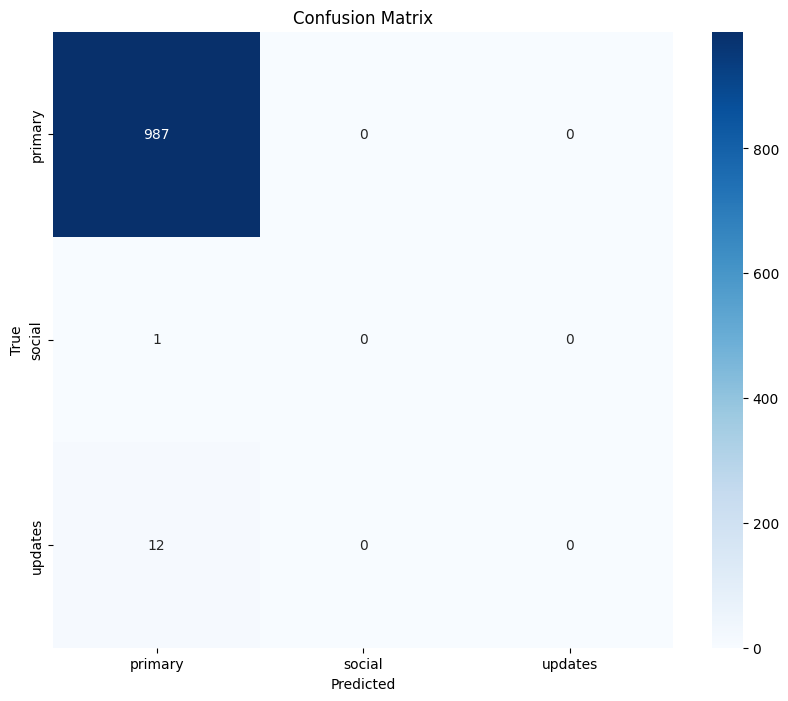

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer # Importing TfidfVectorizer
from sklearn.model_selection import train_test_split # Importing the necessary function
from sklearn.naive_bayes import MultinomialNB # Importing MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix # Importing for model evaluation
import matplotlib.pyplot as plt # Importing for plotting
import seaborn as sns # Importing for heatmap plotting
# Split data
X = emails_df['processed_text']
y = emails_df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**let's create a simple function to classify new emails**

In [12]:
def classify_email(subject, body, sender):
    # Combine and preprocess
    combined_text = subject + ' ' + body
    processed_text = preprocess_text(combined_text)

    # Transform using our vectorizer
    features = vectorizer.transform([processed_text])

    # Predict category
    category = clf.predict(features)[0]

    # Get probabilities for each category
    probabilities = clf.predict_proba(features)[0]
    category_probs = {cat: prob for cat, prob in zip(clf.classes_, probabilities)}

    return category, category_probs

# Test with a sample email
sample_subject = "Team meeting tomorrow"
sample_body = "Hi everyone, Just a reminder that we have our weekly team meeting tomorrow at 2 PM. Please prepare your updates."
sample_sender = "manager@company.com"

category, probs = classify_email(sample_subject, sample_body, sample_sender)
print(f"Predicted category: {category}")
print("Category probabilities:")
for cat, prob in probs.items():
    print(f"- {cat}: {prob:.2f}")

Predicted category: primary
Category probabilities:
- primary: 1.00
- social: 0.00
- updates: 0.00


**Let's set up a function to test multiple examples**

In [13]:
def test_email_filter(test_cases):
    results = []

    for i, case in enumerate(test_cases):
        subject = case['subject']
        body = case['body']
        sender = case['sender']
        expected = case.get('expected', 'Unknown')  # Expected category if provided

        # Classify the email
        category, probs = classify_email(subject, body, sender)

        # Store results
        results.append({
            'Example': i+1,
            'Subject': subject,
            'Sender': sender,
            'Predicted': category,
            'Expected': expected,
            'Confidence': max(probs.values()),
            'Probabilities': probs
        })

    # Display results as a DataFrame
    results_df = pd.DataFrame(results)
    return results_df[['Example', 'Subject', 'Predicted', 'Expected', 'Confidence']]

**Let's create diverse test examples**

In [15]:
test_cases = [
    # Social emails
    {
        'subject': 'Coffee this weekend?',
        'body': "Hey there! It's been a while since we caught up. Want to grab coffee on Saturday?",
        'sender': 'friend@personal.com',
        'expected': 'social'
    },
    # Primary/business emails
    {
        'subject': 'Quarterly Business Review',
        'body': 'Please find attached the Q3 business review document. Key highlights include revenue growth of 12% and new client acquisition rate of 15%.',
        'sender': 'manager@company.com',
        'expected': 'primary'
    },
    # Updates
    {
        'subject': 'Team Meeting Rescheduled',
        'body': 'The weekly team meeting has been moved from Tuesday 2pm to Wednesday 10am. Please update your calendars accordingly.',
        'sender': 'calendar@company.com',
        'expected': 'updates'
    },
    # Spam
    {
        'subject': 'URGENT: Your Account Will Be SUSPENDED',
        'body': 'Dear Valued Customer, Your account will be SUSPENDED in 24 HOURS. Click here immediately to verify your details and claim your $100 reward!!!',
        'sender': 'security@accounts-verify-online.com',
        'expected': 'spam'
    },
    # Ambiguous case
    {
        'subject': 'About your recent order',
        'body': 'Thank you for your recent purchase. Your order #12345 has been shipped and should arrive within 3-5 business days.',
        'sender': 'orders@shopping.com',
        'expected': 'primary'
    }
]

# Test the examples
test_results = test_email_filter(test_cases)
print(test_results)

   Example                                 Subject Predicted Expected  \
0        1                    Coffee this weekend?   primary   social   
1        2               Quarterly Business Review   primary  primary   
2        3                Team Meeting Rescheduled   primary  updates   
3        4  URGENT: Your Account Will Be SUSPENDED   primary     spam   
4        5                 About your recent order   primary  primary   

   Confidence  
0    0.992693  
1    0.999245  
2    0.999066  
3    0.992420  
4    0.998713  


**Let's visualize confidence for each prediction**

<ipython-input-17-f988b22aecb7>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(categories_unique))  # Using a colormap


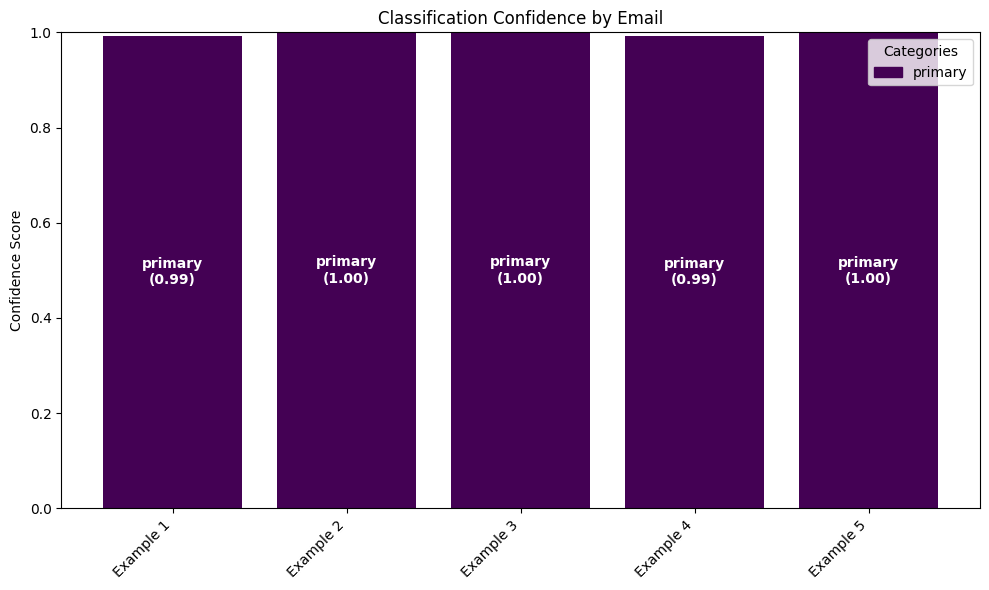

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_cases' and 'classify_email' are defined

# Get prediction data for each test case
predictions = [classify_email(case['subject'], case['body'], case['sender']) for case in test_cases]
categories, probabilities = zip(*predictions)
confidences = [max(probs.values()) for probs in probabilities]

# Create a color map for categories
categories_unique = list(set(categories))
colors = plt.cm.get_cmap('viridis', len(categories_unique))  # Using a colormap
category_colors = {cat: colors(i) for i, cat in enumerate(categories_unique)}

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(test_cases)), confidences, color=[category_colors[cat] for cat in categories])

# Customize the chart
ax.set_xticks(range(len(test_cases)))
ax.set_xticklabels([f"Example {i+1}" for i in range(len(test_cases))], rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.set_ylabel('Confidence Score')
ax.set_title('Classification Confidence by Email')

# Add prediction labels and confidence scores inside the bars
for bar, cat, conf in zip(bars, categories, confidences):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f"{cat}\n({conf:.2f})", ha='center', va='center', color='white', fontweight='bold')

# Add a legend for category colors
handles = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in categories_unique]
ax.legend(handles, categories_unique, title="Categories", loc='upper right')

plt.tight_layout()
plt.show()